In [2]:
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import torch
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import pandas as pd

# Load Model & Dataset

In [3]:
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
secret_label = "hf-token"
secret_value = UserSecretsClient().get_secret(secret_label)

login(secret_value)

In [4]:
# Load Dataset
# Questions, response, and winner info from chatbot arena
ds = load_dataset("lmsys/chatbot_arena_conversations")

README.md:   0%|          | 0.00/7.00k [00:00<?, ?B/s]

(…)-00000-of-00001-cced8514c7ed782a.parquet:   0%|          | 0.00/41.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33000 [00:00<?, ? examples/s]

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Create embeddings for conversation

In [75]:
# extract X questions only from the dataset
questions = [
    record["conversation_a"][0]["content"]
    for record in ds["train"]
    if record["conversation_a"] and record["conversation_a"][0]["role"] == "user"
]

# de-dup while maintain index
seen = set()
unique_questions = []
for q in questions:
    if q not in seen:
        seen.add(q)
        unique_questions.append(q)
print(f'Remaining records after dedup: {len(unique_questions)}')
        
# Encode X records
embeddings = model.encode(unique_questions, show_progress_bar=True)

# Save embeddings
np.save("all-MiniLM-L6-v2_30k_embeddings.npy", embeddings)

Remaining records after dedup: 26968


Batches:   0%|          | 0/843 [00:00<?, ?it/s]

## Load Precomputed Embeddings (OPTIONAL)

In [ ]:
embeddings = np.load("all-MiniLM-L6-v2_30k_embeddings.npy")

# Similarity Search
## Encode some records, find the similar one when get a new entry

In [8]:
def find_similar_question(embeddings,texts, query, top_k=1):
    """Enter some string and find top_k most similar ones"""
    # encode new question
    query_embedding = model.encode([query], show_progress_bar=False) 

    # find similary ones from embeddings
    similarity = cosine_similarity(query_embedding, embeddings)
    top_indices = np.argsort(similarity[0])[::-1][:top_k] # sort the index of similarity scores, reverse it (descending), take top k 

    output = []

    for i, index in enumerate(top_indices):
        result = {
            'rank': i+1,
            'similarity_score': f"{similarity[0][index]:.4f}",
            'search_result': texts[index]
        }
        output.append(result)

    return output

In [9]:
find_similar_question(embeddings, unique_questions, "recommend me a car", top_k=5)

[{'rank': 1,
  'similarity_score': '0.6326',
  'search_result': "I'M THINKING OF A CAR"},
 {'rank': 2,
  'similarity_score': '0.6005',
  'search_result': 'What should I consider when buying a car?'},
 {'rank': 3,
  'similarity_score': '0.5849',
  'search_result': 'Suggest a used car under 5000 dollars budget'},
 {'rank': 4,
  'similarity_score': '0.5532',
  'search_result': "You are a chatbot that recommends vehicles related to a users interests. Recommend 5 similar makes and models as a bulleted list, without explanatory text, and don't recommend the same manufacturer as the user's interest. \n\nI am interested in a 1963 Porsche 911. Suggest 5 similar vehicles."},
 {'rank': 5,
  'similarity_score': '0.5333',
  'search_result': "You are a chatbot that recommends vehicles related to a users interests. Recommend 5 similar makes and models as a bulleted list, without explanatory text, and don't recommend the same manufacturer as the user's interest. \n\nI am interested in a 1995 Acura NSX

# Clustering

## K-means

## sklearn on CPU

In [ ]:
# Tune # of cluster
scores = []
k_range = range(25, 81)

for k in tqdm(k_range):
    kmeans = KMeans(n_clusters=k, n_init=15, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, scores, marker='o', color='orange')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('k (Number of clusters)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

In [ ]:
num_clusters = 55
kmeans = KMeans(n_clusters=num_clusters, n_init=15, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings) 

## cuml on GPU

In [13]:
from cuml.cluster import KMeans as cuKMeans # gpu for kmean
from sklearn.metrics import silhouette_score # cpu for score
import cupy as cp

100%|██████████| 56/56 [12:27<00:00, 13.35s/it]


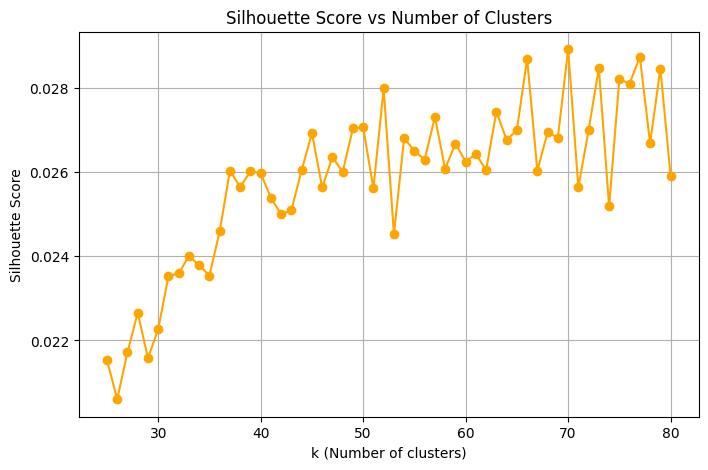

In [16]:
# move embedding from numpy to cupy
embeddings_gpu = cp.asarray(embeddings)
scores = []
k_range = range(25, 81)

for k in tqdm(k_range):
    kmeans = cuKMeans(n_clusters=k, n_init=15, random_state=42)
    labels = kmeans.fit_predict(embeddings_gpu)

    # Move to CPU
    labels_cpu = cp.asnumpy(labels)
    embeddings_cpu = cp.asnumpy(embeddings_gpu)

    score = silhouette_score(embeddings_cpu, labels_cpu)
    scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, scores, marker='o', color='orange')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('k (Number of clusters)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [18]:
# run GPU KMeans
num_clusters = 52
kmeans = cuKMeans(n_clusters=num_clusters, n_init=15, random_state=42)
cluster_labels_gpu = kmeans.fit_predict(embeddings_gpu)

# bring labels back to CPU if needed
cluster_labels = cp.asnumpy(cluster_labels_gpu)

In [24]:
# See sample records from a cluster
indices_1 = np.where(cluster_labels==10)[0][:5]
selected_questions = [unique_questions[i] for i in indices_1]
selected_questions

['Write a python one-line lambda function that calculates dot product between two lists without using imported libraries. The entire function must fit on a single line and should begin like this: dot = lambda A, B: ',
 'Write a python one line lambda function that calculates mean of two lists, without using any imported libraries. The entire function should fit on a single line, start with this. mean = lambda A:',
 'write a bubble sort in python',
 'Write a Python program which performs sequence alignment. We need to find a substring in longer text using approximate match.',
 'Write a python program to reverse a string ']

# Auto-Label each cluster

# Find most representative convo from each cluster

In [21]:
# see cluster size
values, counts = np.unique(cluster_labels, return_counts=True)

for val, count in zip(values, counts):
    print(f"Value: {val}, Count: {count}")

Value: 0, Count: 803
Value: 1, Count: 316
Value: 2, Count: 935
Value: 3, Count: 547
Value: 4, Count: 1111
Value: 5, Count: 474
Value: 6, Count: 593
Value: 7, Count: 512
Value: 8, Count: 452
Value: 9, Count: 316
Value: 10, Count: 883
Value: 11, Count: 296
Value: 12, Count: 600
Value: 13, Count: 487
Value: 14, Count: 209
Value: 15, Count: 378
Value: 16, Count: 632
Value: 17, Count: 538
Value: 18, Count: 439
Value: 19, Count: 196
Value: 20, Count: 918
Value: 21, Count: 435
Value: 22, Count: 612
Value: 23, Count: 438
Value: 24, Count: 632
Value: 25, Count: 428
Value: 26, Count: 717
Value: 27, Count: 697
Value: 28, Count: 540
Value: 29, Count: 402
Value: 30, Count: 155
Value: 31, Count: 648
Value: 32, Count: 430
Value: 33, Count: 403
Value: 34, Count: 503
Value: 35, Count: 467
Value: 36, Count: 609
Value: 37, Count: 538
Value: 38, Count: 478
Value: 39, Count: 263
Value: 40, Count: 460
Value: 41, Count: 629
Value: 42, Count: 334
Value: 43, Count: 444
Value: 44, Count: 497
Value: 45, Count: 7

In [37]:
# pick most representative records from each cluster
rep_records = {}
for i in range(kmeans.n_clusters):
    # get indices for the cluster
    cluster_indices = list(np.where(cluster_labels==i)[0])
    
    # get embeddings for the cluster — convert to numpy if needed
    cluster_embeddings = embeddings[cluster_indices]
    if hasattr(cluster_embeddings, "get"):
        cluster_embeddings = cluster_embeddings.get()

    # get centroid for cluster i — convert to numpy if needed
    centroid = kmeans.cluster_centers_[i].reshape(1, -1)
    if hasattr(centroid, "get"):
        centroid = centroid.get()
        
    # calculate distance of all points to the centroid
    distance = cosine_distances(cluster_embeddings, centroid).flatten()
    
    # get X most representative indices in the cluster
    if sum(cluster_labels==i) <= 100:
       num_sample = max(10,int(sum(cluster_labels==i) * 0.15))
    else:
        num_sample = min(50,int(sum(cluster_labels==i) * 0.1))
     
    candidate_indices = np.argsort(distance)[:num_sample]
    output_indices = [cluster_indices[idx] for idx in candidate_indices] # map idx back to cluster_indices
    # get x most representative questions in the cluster
    output_quesitons = [unique_questions[idx] for idx in output_indices]
    rep_records[f'cluster_{i}'] = output_quesitons

In [44]:
for k,v in rep_records.items():
    print(f'Cluster: {k} - Sample Size: {len(v)}')

Cluster: cluster_0 - Sample Size: 50
Cluster: cluster_1 - Sample Size: 31
Cluster: cluster_2 - Sample Size: 50
Cluster: cluster_3 - Sample Size: 50
Cluster: cluster_4 - Sample Size: 50
Cluster: cluster_5 - Sample Size: 47
Cluster: cluster_6 - Sample Size: 50
Cluster: cluster_7 - Sample Size: 50
Cluster: cluster_8 - Sample Size: 45
Cluster: cluster_9 - Sample Size: 31
Cluster: cluster_10 - Sample Size: 50
Cluster: cluster_11 - Sample Size: 29
Cluster: cluster_12 - Sample Size: 50
Cluster: cluster_13 - Sample Size: 48
Cluster: cluster_14 - Sample Size: 20
Cluster: cluster_15 - Sample Size: 37
Cluster: cluster_16 - Sample Size: 50
Cluster: cluster_17 - Sample Size: 50
Cluster: cluster_18 - Sample Size: 43
Cluster: cluster_19 - Sample Size: 19
Cluster: cluster_20 - Sample Size: 50
Cluster: cluster_21 - Sample Size: 43
Cluster: cluster_22 - Sample Size: 50
Cluster: cluster_23 - Sample Size: 43
Cluster: cluster_24 - Sample Size: 50
Cluster: cluster_25 - Sample Size: 42
Cluster: cluster_26 - 

In [46]:
rep_records['cluster_0'][:10]

['what is this service about',
 'what is this https://github.com/StephanJoubert/home_assistant_solarman',
 'What does /r9k/ stand for?',
 'what is vector database pinecone?',
 'What is toric code?',
 "can you explain what is MQTT in few lines and outline it's major propreties?",
 'explain what the program Discord is and how it works in simple terms.',
 'Can you tell me what is a turbocompressor?',
 'What are some obscure functions of Cheat Engine?',
 'Can you tell me what I2C stands for ?']

## LLM Calling

In [52]:
prompt = """
<Background>
You are given a cluster of some text samples from users questions to a LLM chatbot, grouped by semantic similarity.
<\Background>

<Task>
1. Analyze the texts and identify the common topic, theme, or intent that unifies them.
2. If a clear common theme exists, generate a **concise label** (2–5 words) that best summarizes it.
3. If there is no clear topical theme, but the texts are all in the same language (e.g., Chinese, European Langauge), return a label like "Chinese Language Cluster".
3. If the texts are too diverse or noisy, do not appear to share a coherent theme, and liguistically noisy, give label as 'cluster is too noisy'.
<\Task>

<Output Format>
Output your response strictly in the following JSON format:
{{
  "thinking": "<Brief explanation of how you arrived at your label or why the cluster is too noisy>",
  "decision": "<Concise label if clear, otherwise return 'Cluster too noisy to label'>"
}}
<\Output Format>

<Texts from the Cluster>
{cluster}
<\Texts from the Cluster>
"""

In [54]:
# prompt preview
for key, value in list(rep_records.items())[:1]:
    formated_text = joined_string = "\n".join(value) # turn list of strings to strings separaetd by new line
    inputs=prompt.format(cluster=formated_text)
    print(key)
    print(inputs)

cluster_0

<Background>
You are given a cluster of some text samples from users questions to a LLM chatbot, grouped by semantic similarity.
<\Background>

<Task>
1. Analyze the texts and identify the common topic, theme, or intent that unifies them.
2. If a clear common theme exists, generate a **concise label** (2–5 words) that best summarizes it.
3. If there is no clear topical theme, but the texts are all in the same language (e.g., Chinese, European Langauge), return a label like "Chinese Language Cluster".
3. If the texts are too diverse or noisy, do not appear to share a coherent theme, and liguistically noisy, give label as 'cluster is too noisy'.
<\Task>

<Output Format>
Output your response strictly in the following JSON format:
{
  "thinking": "<Brief explanation of how you arrived at your label or why the cluster is too noisy>",
  "decision": "<Concise label if clear, otherwise return 'Cluster too noisy to label'>"
}
<\Output Format>

<Texts from the Cluster>
what is this se

In [55]:
from openai import OpenAI

secret_label_1 = "OpenAI API Key"
secret_value_1 = UserSecretsClient().get_secret(secret_label_1)

client = OpenAI(api_key=secret_value_1)

In [56]:
rows = []
for key, value in tqdm(rep_records.items()):
    # call openai
    response = client.responses.create(
        model="gpt-4.1-mini",
        input=prompt.format(cluster=value)
    )
    
    model_output = response.output_text

    # store sample length
    length = len(value)

    # Append to list
    rows.append({
        "cluster": key,
        "sample_data_size":length,
        "sample_data": value,
        "model_output": model_output
    })
df = pd.DataFrame(rows)
df.head()

100%|██████████| 52/52 [02:11<00:00,  2.53s/it]


,cluster,sample_data_size,sample_data,model_output
0,cluster_0,50,"[what is this service about, what is this http...","{\n ""thinking"": ""All the texts are questions ..."
1,cluster_1,31,"[你能夠理解繁體中文，並使用繁體中文回答我問題嗎？, 你可以用中文和我交談嗎？, 足球球员于...","{\n ""thinking"": ""The majority of texts in the..."
2,cluster_2,50,[Rédige un texte détaillant les 10 combinaison...,"{\n ""thinking"": ""The texts are a diverse set ..."
3,cluster_3,50,[{\n 'balancesheet': [{'date': '2023-01-31'...,"{\n ""thinking"": ""All texts focus on interpret..."
4,cluster_4,50,[Please act as an expert frontend and Node.JS ...,"{\n ""thinking"": ""The majority of the texts fo..."


### Parse thiking and final cluster label from model output

In [57]:
import json
import re

def parse_model_output(text):
    # remove code block markers like ```json or ```
    cleaned_text = re.sub(r"^```(?:json)?\s*|\s*```$", "", text.strip(), flags=re.MULTILINE)

    # try to parse JSON
    try:
        parsed = json.loads(cleaned_text)
        thinking = parsed.get("thinking", "").strip()
        decision = parsed.get("decision", "").strip()
    except json.JSONDecodeError:
        thinking = ""
        decision = ""
    
    return thinking, decision

In [58]:
df[['thinking','cluster_label']] = df['model_output'].apply(lambda x: pd.Series(parse_model_output(x)))
df

,cluster,sample_data_size,sample_data,model_output,thinking,cluster_label
0,cluster_0,50,"[what is this service about, what is this http...","{\n ""thinking"": ""All the texts are questions ...",All the texts are questions asking for explana...,Technical Concept Explanations
1,cluster_1,31,"[你能夠理解繁體中文，並使用繁體中文回答我問題嗎？, 你可以用中文和我交談嗎？, 足球球员于...","{\n ""thinking"": ""The majority of texts in the...",The majority of texts in the cluster are in Ch...,Chinese Language Queries
2,cluster_2,50,[Rédige un texte détaillant les 10 combinaison...,"{\n ""thinking"": ""The texts are a diverse set ...",The texts are a diverse set of user questions ...,Cluster too noisy to label
3,cluster_3,50,[{\n 'balancesheet': [{'date': '2023-01-31'...,"{\n ""thinking"": ""All texts focus on interpret...","All texts focus on interpreting, classifying, ...",Financial Document Data Processing
4,cluster_4,50,[Please act as an expert frontend and Node.JS ...,"{\n ""thinking"": ""The majority of the texts fo...",The majority of the texts focus on requests fo...,Web Development Coding Help
5,cluster_5,47,[Write me an email responding to my manager as...,"{\n ""thinking"": ""All texts in the cluster are...",All texts in the cluster are user requests to ...,Email and Letter Writing
6,cluster_6,50,[Please write some of the implicit rules that ...,"{\n ""thinking"": ""The majority of texts revolv...",The majority of texts revolve around themes of...,Ethics and Social Behavior
7,cluster_7,50,"[Tell me your favorite type of food. , How do ...","{\n ""thinking"": ""All texts revolve around foo...",All texts revolve around food-related inquirie...,Food and Cooking Queries
8,cluster_8,45,"[How much bigger is the sun than the moon?, wh...","```json\n{\n ""thinking"": ""The majority of que...",The majority of questions revolve around astro...,Astronomy and Space Facts
9,cluster_9,31,"[What date is today?, what is the date today?,...","{\n ""thinking"": ""All the texts are centered a...",All the texts are centered around queries abou...,Today's Date Queries


In [59]:
df.to_csv('30k_convo_kmean52_41mini_prompt3.csv')

# Classify unseen Text

In [65]:
centroids = kmeans.cluster_centers_
# move to cpu if on gpu
if hasattr(centroids, "get"):
        centroids = centroids.get()
print(f'Centroids Shape: {centroids.shape}')

labels = df['cluster_label'].to_list()
print(f'Labels Length: {len(labels)}')

Centroids Shape: (52, 384)
Labels Length: 52


In [67]:
def assign_label(free_text, threshold=0):
    # input check
    if isinstance(free_text, str):
        formated_input = [free_text]
    elif isinstance(free_text, list) and all(isinstance(text,str) for text in free_text):
        formated_input = free_text
    else:
        raise ValueError('Input needs to string, or list of string.')
        
    # encode free text to embedding
    free_text_embedding = model.encode(formated_input)

    # calculate similarity with centroids
    similarity_score = cosine_similarity(free_text_embedding, centroids)

    # assign labels
    results = []
    for sim in similarity_score:
        best_idx = np.argmax(sim)
        best_sim = sim[best_idx]
        if best_sim >= threshold:
            results.append((labels[best_idx], best_sim))
        else:
            results.append((None, best_sim))
            
    return results

In [83]:
questions_list = [
    'how to write a for loop in Python',
    'Why is LLM deconder-only?',
    '你好，今天天气怎么样',
    'How to make a cheese burger but vegan?',
    'I dont want to go to work tomorrow, what should i do',
    'Do you want to take over the earth and rule all human beings?',
    'How to find a software engineer job?',
    '800//3=?',
    'If I am the first human being in the earth, who is my parent?'
    'Who are you?'
]
assign_label(questions_list)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

[('Python Programming Requests', 0.62989116),
 ('Large Language Models (LLMs)', 0.6010575),
 ('Chinese Language Queries', 0.68190485),
 ('Food and Cooking Queries', 0.49580196),
 ('Productivity and Self-Improvement', 0.550792),
 ('Global History and Geopolitics', 0.3667635),
 ('Learning and Skill Development', 0.49285716),
 ('Number and Arithmetic Queries', 0.45805672),
 ('AI Identity and Roleplay', 0.434623)]